## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")

## Choose PUMS and Preprocess

In [3]:
#Variables for testing; filter to cols and drop na vars
pums_data = p_df[['AGEP','COW','JWMNP','MAR','SCHL','SEX','PINCP']]
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=359075 pre-cleaning
Dataset n=152416 post-cleaning


In [4]:
#Split categorical data into OHE binary vars
cow_dummies = pd.get_dummies(pums_data['COW'], prefix='COW')
mar_dummies = pd.get_dummies(pums_data['MAR'], prefix='MAR')
sex_dummies = pd.get_dummies(pums_data['SEX'], prefix='SEX')
pums_data_numeric = pums_data[['AGEP','JWMNP','SCHL','PINCP']]

#Data after encoding
model_data_df = pd.concat([pums_data_numeric, cow_dummies, mar_dummies, sex_dummies], axis=1)
model_data_df

,AGEP,JWMNP,SCHL,PINCP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0,MAR_1,MAR_2,MAR_3,MAR_4,MAR_5,SEX_1,SEX_2
4,52,70.0,21.0,160000.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,51,20.0,21.0,50000.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
7,59,30.0,19.0,26710.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
8,56,15.0,16.0,23600.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
9,40,5.0,5.0,10000.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359058,21,4.0,19.0,2700.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
359065,21,90.0,14.0,8200.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
359070,22,35.0,16.0,37200.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
359071,19,7.0,18.0,5300.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [5]:
#Standardize the input data from -1 to 1 and remove outliers (>2std)
scaler = skpre.StandardScaler()
model_data = model_data_df.values
model_data = scaler.fit_transform(model_data)

#Separate into train/test data
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]
train_data

array([[ 0.63623035,  1.83970982,  0.68939993, ..., -0.61041799,
         0.9302304 , -0.9302304 ],
       [ 0.56578925, -0.31801862,  0.68939993, ..., -0.61041799,
        -1.07500249,  1.07500249],
       [ 1.12931806,  0.11352707,  0.05435252, ..., -0.61041799,
         0.9302304 , -0.9302304 ],
       ...,
       [ 0.98843585, -0.7495643 , -0.26317119, ...,  1.63822172,
        -1.07500249,  1.07500249],
       [ 0.28402485, -0.53379146, -0.26317119, ..., -0.61041799,
        -1.07500249,  1.07500249],
       [ 0.00226044,  0.7608456 ,  0.05435252, ...,  1.63822172,
        -1.07500249,  1.07500249]])

## Set Model and Parameters

In [6]:
#Hyperparameters
batch_size = 64
epochs = 100
learning_rate = 0.001
rho = 0.9
latent_dim = 4
manifest_dim = model_data.shape[1]
hidden_dim = 50

#TODO:
#Figure out loss function for categorical variables that isn't regression
#Throw out outliers/verify data processing is giving good distributions
#Verify the distributions of the z variables
#Find way to test similarity of joint distributions at end
#Test speeds for sampling new people
#Disentangled VAE
#Build a GAN
#Test household/person combinations
#Test new combinations of hyperparameters

In [7]:
#A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs): #Keras method that defines the layer outputs
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [8]:
#Encoder
encoder_inputs = keras.Input(shape=(manifest_dim,), name="inputlayer")
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer1")(encoder_inputs)
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer2")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputlayer (InputLayer)         [(None, 19)]         0                                            
__________________________________________________________________________________________________
denselayer1 (Dense)             (None, 50)           1000        inputlayer[0][0]                 
__________________________________________________________________________________________________
denselayer2 (Dense)             (None, 50)           2550        denselayer1[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            204         denselayer2[0][0]                
____________________________________________________________________________________________

In [9]:
#Decoder
latent_inputs = keras.Input(shape=(latent_dim,),name="inputlayer")
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer1")(latent_inputs)
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer2")(x)
decoder_outputs = layers.Dense(manifest_dim, activation="linear", name="linear_outputs")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (InputLayer)      [(None, 4)]               0         
_________________________________________________________________
denselayer1 (Dense)          (None, 50)                250       
_________________________________________________________________
denselayer2 (Dense)          (None, 50)                2550      
_________________________________________________________________
linear_outputs (Dense)       (None, 19)                969       
Total params: 3,769
Trainable params: 3,769
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction):
    data_num = data[0][:,:3]
    data_cat = data[0][:,4:]
    reconstruction_num = reconstruction[:,:3]
    reconstruction_cat = reconstruction[:,4:]
            
    #Mean squared error for numerical variables
    reconstruction_loss_numerical = keras.losses.mean_squared_error(data, reconstruction)
    reconstruction_loss_numerical = tf.reduce_mean(reconstruction_loss_numerical)
    
    #Categorical cross entropy for categorical variables
    #reconstruction_loss_categorical = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat)
    #reconstruction_loss_categorical = tf.reduce_mean(reconstruction_loss_categorical)

    return reconstruction_loss_numerical

In [11]:
#Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            #Get latent vars from the encoder; feed to decoder and get manifest
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            
            #Get loss between expected values and actual from decoder
            reconstruction_loss = get_reconstruction_loss(data, reconstruction)
            reconstruction_loss *= 4

            #Get Kullback Leidler loss between normal distribution and actual
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -0.5 * tf.reduce_mean(kl_loss)
            
            #Combine into single loss term
            total_loss = reconstruction_loss + kl_loss
        
        #Get new gradients given the loss and take another step, also return losses
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

## Training

In [12]:
#Train
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho))
history = vae.fit(train_data, epochs=epochs, batch_size=batch_size)

Epoch 1/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 2.4945 - reconstruction_loss: 1.8796 - kl_loss: 0.6149
Epoch 2/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 1.5612 - reconstruction_loss: 0.8360 - kl_loss: 0.7252
Epoch 3/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 1.3246 - reconstruction_loss: 0.5864 - kl_loss: 0.7382
Epoch 4/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 1.2347 - reconstruction_loss: 0.5007 - kl_loss: 0.7340
Epoch 5/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 1.1903 - reconstruction_loss: 0.4548 - kl_loss: 0.7355
Epoch 6/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 1.1560 - reconstruction_loss: 0.4216 - kl_loss: 0.7344
Epoch 7/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 1.1305 - reconstruction_loss: 0.3964 - kl_loss: 0.7341
Epoch 8/100
2144/2144 [===========

2144/2144 [==============================] - 8s 4ms/step - total_loss: 0.9827 - reconstruction_loss: 0.2699 - kl_loss: 0.7127
Epoch 61/100
2144/2144 [==============================] - 7s 3ms/step - total_loss: 0.9808 - reconstruction_loss: 0.2698 - kl_loss: 0.7110
Epoch 62/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 0.9821 - reconstruction_loss: 0.2714 - kl_loss: 0.7107
Epoch 63/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 0.9792 - reconstruction_loss: 0.2692 - kl_loss: 0.7100
Epoch 64/100
2144/2144 [==============================] - 7s 3ms/step - total_loss: 0.9806 - reconstruction_loss: 0.2704 - kl_loss: 0.7103
Epoch 65/100
2144/2144 [==============================] - 6s 3ms/step - total_loss: 0.9804 - reconstruction_loss: 0.2703 - kl_loss: 0.7101
Epoch 66/100
2144/2144 [==============================] - 7s 3ms/step - total_loss: 0.9808 - reconstruction_loss: 0.2697 - kl_loss: 0.7110
Epoch 67/100
2144/2144 [================

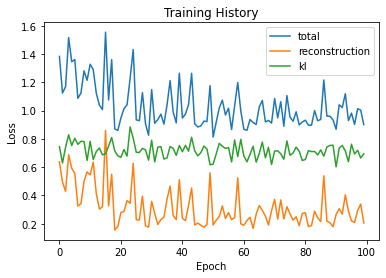

In [13]:
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","reconstruction","kl"], loc="upper right")
plt.show()

## Testing

In [37]:
#Draw predictions from test data
results = vae.predict(test_data)

#Transform back to real variable values
results = scaler.inverse_transform(results)
results = np.round(results, 0)

#Rescale test_data dataframe and view results
results_df = pd.DataFrame(results)
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data))

#Numpy likes to leave floats as -0.0 so replace all 0's with 0
results_df[results_df==0.] = 0.

#View data
results_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,26.0,28.0,18.0,27873.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,47.0,11.0,22.0,354121.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,50.0,24.0,21.0,449296.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,52.0,11.0,18.0,56843.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,61.0,14.0,21.0,64347.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15237,24.0,12.0,19.0,14336.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
15238,23.0,62.0,13.0,24566.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
15239,27.0,20.0,18.0,36735.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
15240,21.0,12.0,17.0,7948.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [38]:
test_data_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,31.0,30.0,17.0,73000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,55.0,10.0,22.0,454900.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,54.0,15.0,21.0,478000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,64.0,10.0,16.0,60000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,65.0,10.0,20.0,83000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15237,21.0,4.0,19.0,2700.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
15238,21.0,90.0,14.0,8200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
15239,22.0,35.0,16.0,37200.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
15240,19.0,7.0,18.0,5300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


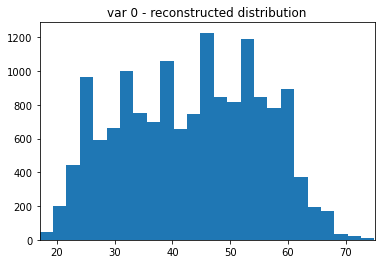

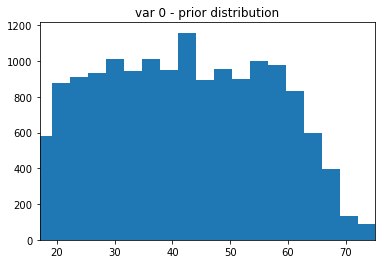

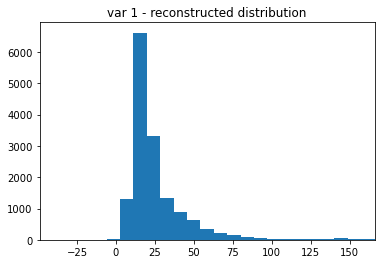

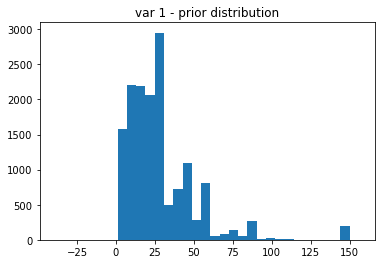

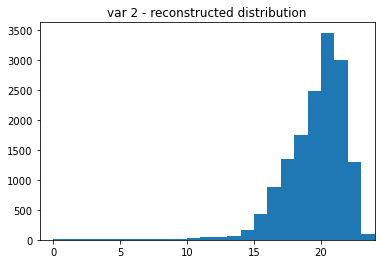

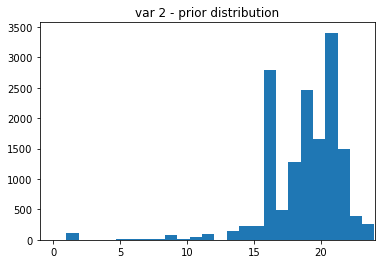

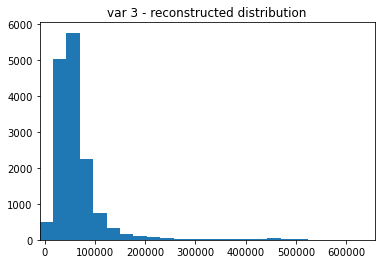

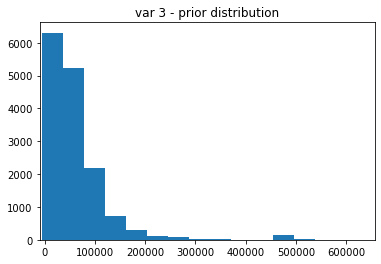

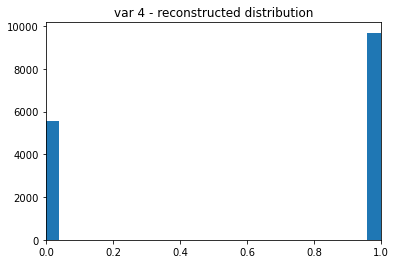

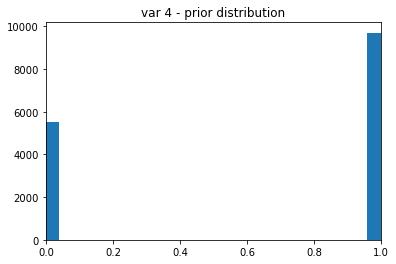

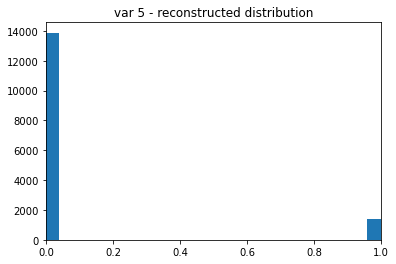

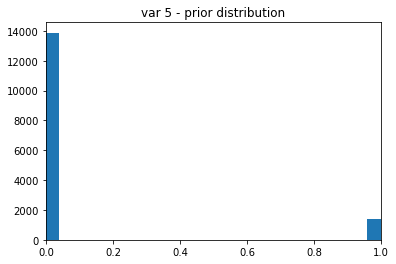

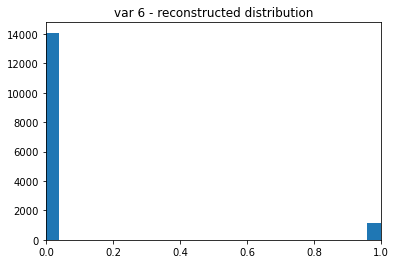

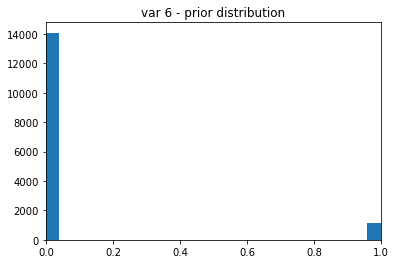

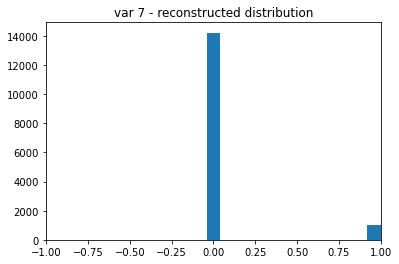

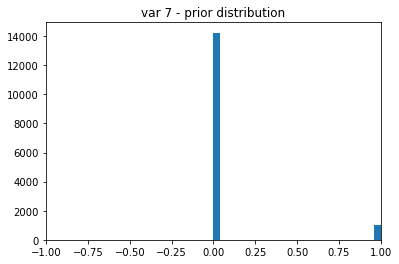

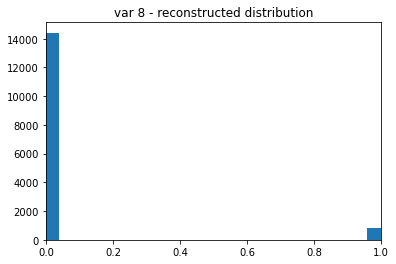

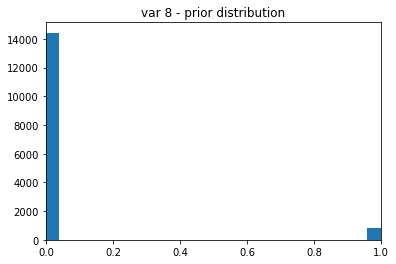

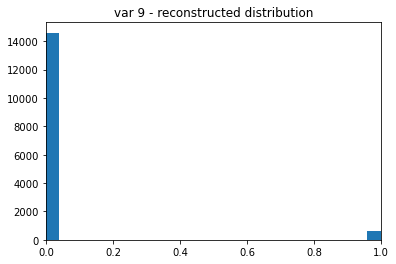

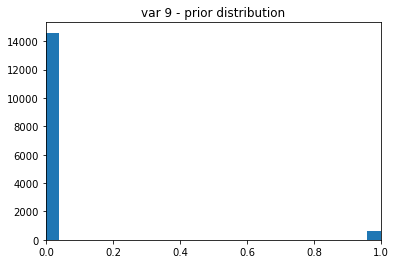

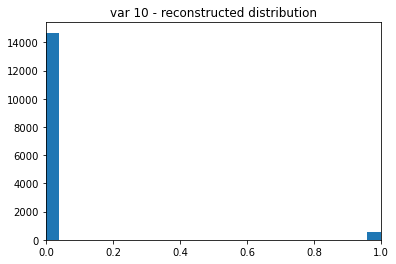

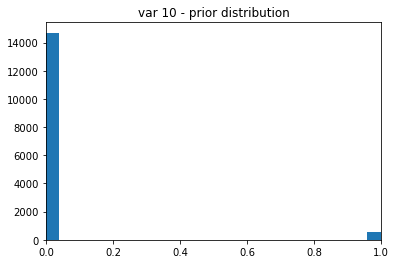

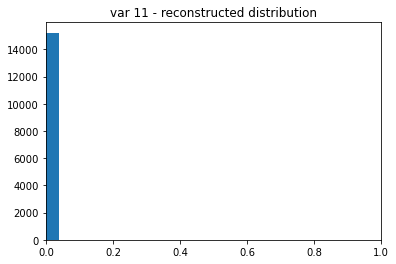

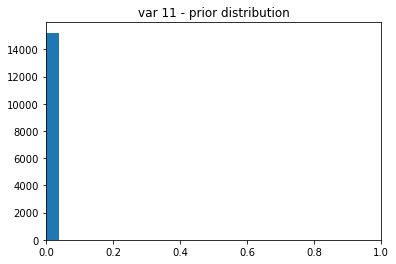

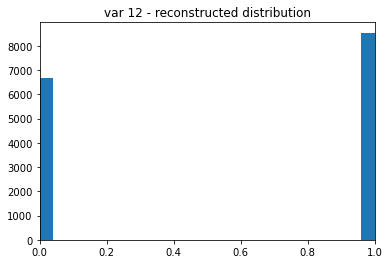

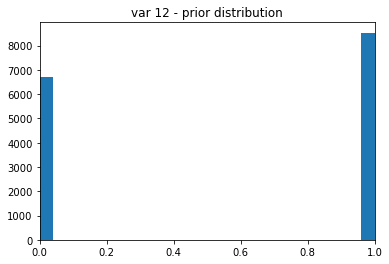

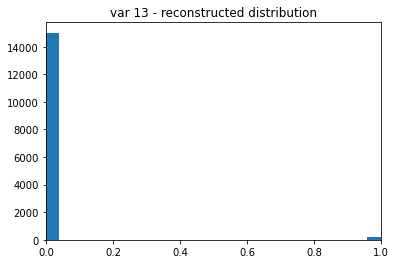

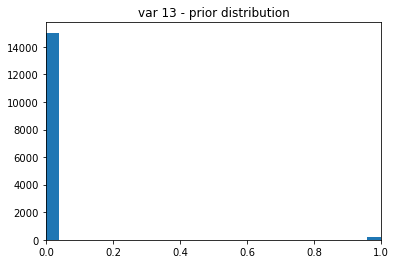

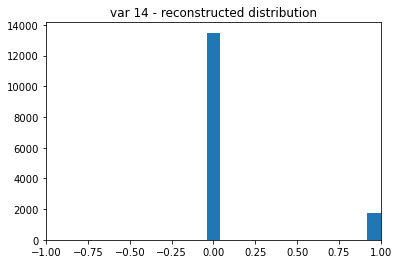

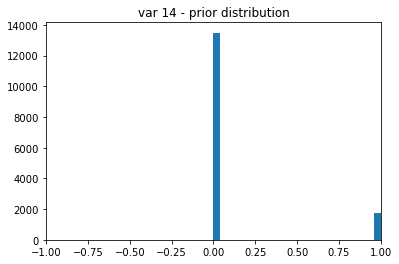

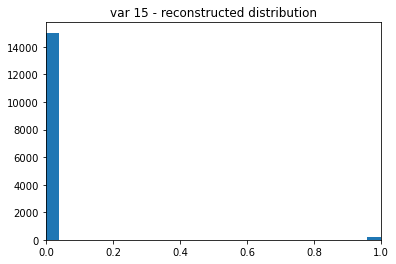

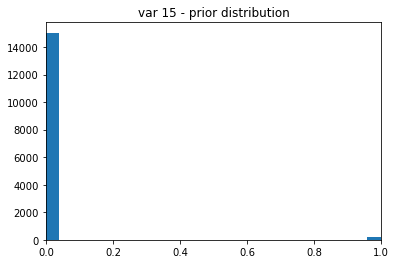

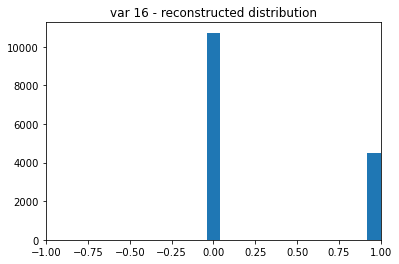

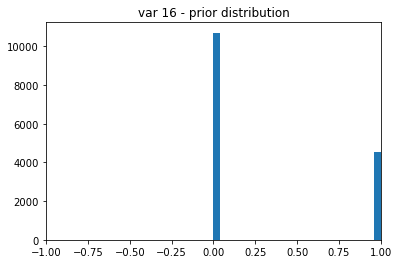

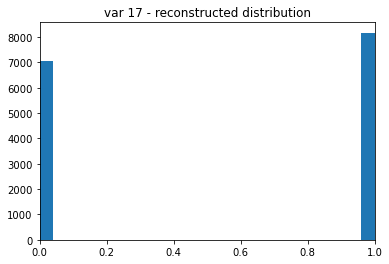

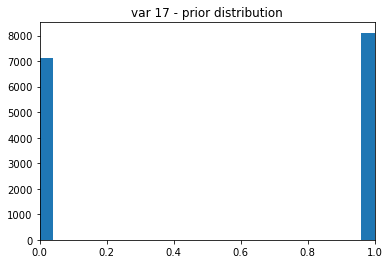

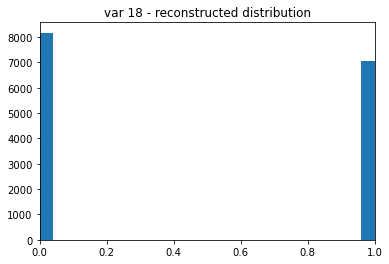

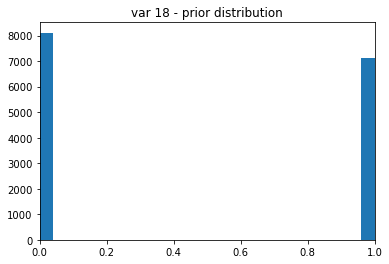

In [39]:
#Show distributions of the resulting variables
for col_idx in range(0,results.shape[1]):
    plt.hist(results[:,col_idx], bins=25)
    plt.xlim(min(results[:,col_idx]),max(results[:,col_idx]))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    plt.hist(test_data_df.values[:,col_idx], bins=25)
    plt.xlim(min(results[:,col_idx]),max(results[:,col_idx]))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()